In [14]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

## load TOOCAN
# from load_TOOCAN_DYAMOND_modif import load_TOOCAN_DYAMOND
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND
from conditionalstats import Distribution
import plot1D as p1d

## current script object
thismodule = sys.modules[__name__]

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM']


# Load data

In [87]:
SST = 300
varid = 'Prec'

def loadVarRCEMIP(varid,SST):
    
    fileroot = '%s_rcemip_large_2048x128x74_3km_12s_%sK_64.2Dcom.nc'
    filename = fileroot%(varid,SST)
    var = xr.open_dataset(os.path.join(DIR_RCEMIP,"%sK"%SST,filename))[varid]
    
    return var

def loadTOOCANSEG_RCEMIP(SST):
    
    fileroot = 'TOOCAN_2.07_SAM_RCE_large%s_2D_irtb.nc'
    filename = fileroot%SST
    toocanseg = xr.open_dataset(os.path.join(DIR_TOOCANSEG_RCEMIP,filename))['MCS_label']
    
    return toocanseg

In [102]:
mmd_to_mmhr = 1/24

Prec_300 = loadVarRCEMIP('Prec',300)*mmd_to_mmhr
PW_300 = loadVarRCEMIP('PW',300)
TOOCANSEG_300 = loadTOOCANSEG_RCEMIP(300)

In [113]:
PW_305 = loadVarRCEMIP('PW',305)
TOOCANSEG_305 = loadTOOCANSEG_RCEMIP(305)

In [94]:
def getTOOCANmask(toocan_seg):

    # boolean mask
    toocan_mask = toocan_seg.data.flatten() > 0
    
    return toocan_mask

def getVarThresholdMask(var,thres):

    # # assume mask string format is $varid_$thres
    # varid,thres = tuple(mask.split('_'))

    # define boolean mask
    var_mask = var.data.flatten() > float(thres)
    
    return var_mask

In [99]:
mask_TOOCAN = getTOOCANmask(TOOCANSEG_300)
mask_PW_40 = getVarThresholdMask(PW_300,40)

In [100]:
mask_PW_40_TOOCAN = np.logical_and(mask_PW_40,mask_TOOCAN)

In [101]:
def getFrac(mask):
    return np.sum(np.array(mask,dtype=int))/mask.size

print(getFrac(mask_TOOCAN),getFrac(mask_PW_40),getFrac(mask_PW_40_TOOCAN))

0.03759089715276332 0.3381019643105436 0.03560268710197557


In [38]:
varid = 'Prec'

#---- Compute distribution

# initialize
dist_prec_300 = Distribution(name='%s, RCEMIP-SAM %sK'%(varid,SST),nbins=50,bintype='invlogQ')
# data
data_1D = prec_300.data.flatten()
# compute distribution
dist_prec_300.computeDistribution(sample=data_1D)

/home/bfildier/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Percentiles ')

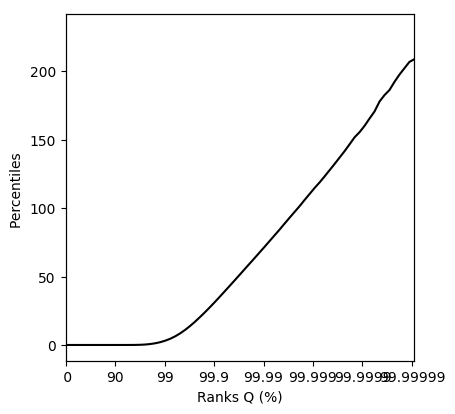

In [45]:
#---- show distribution

dist = dist_prec_300

fig,ax = plt.subplots(ncols=1,figsize=(4.5,4.5))

ranks = dist.ranks
perc = dist.percentiles

#--- on IL x axis
ax_show = ax.twiny()

#- set frame
p1d.setXaxisIL(ax,ranks)

#- show data
p1d.showData(ax_show,ranks,perc, c='k',rankmin=0, rankmax = 99.99999)

#- labels
ax.set_xlabel('Ranks Q (%)')
ax.set_ylabel('Percentiles ')

In [42]:
np.max(prec_300)

<xarray.DataArray 'Prec' ()>
array(276.46472168)

# Some figures

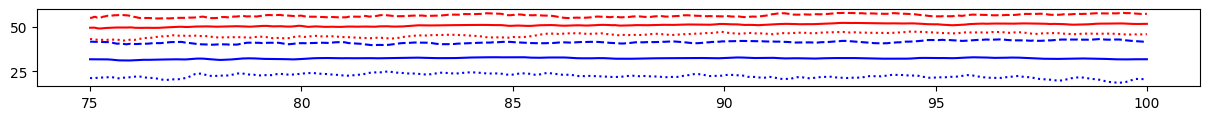

In [150]:
# Time series of PW

SSTs = 300,305 # K
cols = 'b','r'
N=1

time = PW_300.time

fig,ax = plt.subplots(nrows=1,figsize=(15,2*N-1))

for SST,i_ax,col in zip(SSTs,(0,1),cols):
    
    # data
    PW = getattr(thismodule,'PW_%s'%SST)
    # print(PW.data)
    PW_25th = np.percentile(PW.data,25,axis=(1,2))
    PW_75th = np.percentile(PW.data,75,axis=(1,2))
    PW_1D = np.mean(np.mean(PW.data,axis=1),axis=1)
    ax.plot(time,PW_1D,c=col)
    ax.plot(time,PW_25th,':',c=col)
    ax.plot(time,PW_75th,'--',c=col)

In [ ]:
# PDFs of PW

np.histogram()

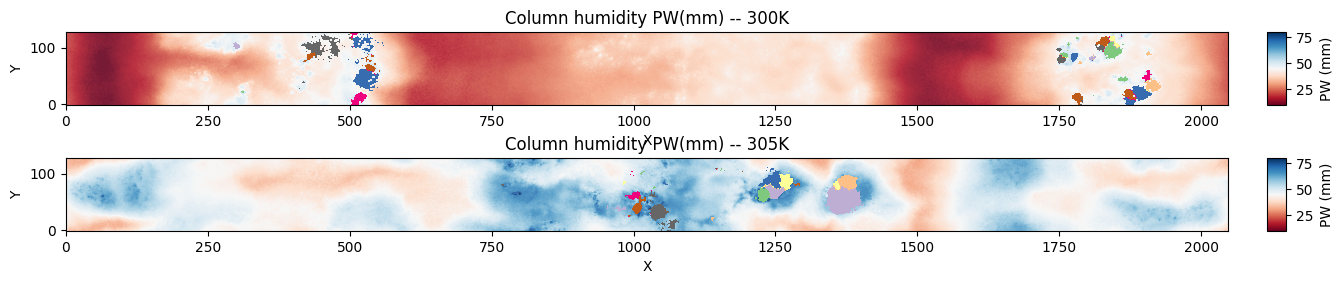

In [140]:
def showColorBar(fig,ax,im):
    
    x,y,w,h = ax.get_position().bounds
    dx = w/60
    cax = plt.axes([x+w+2*dx,y,dx,h])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('PW (mm)')
    
cmap = plt.cm.RdBu
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)

SSTs = 300,305 # K
N=2

fig,axs = plt.subplots(nrows=N,figsize=(15,2*N-1))


for SST,i_ax in zip(SSTs,(0,1)):

    ax = axs[i_ax]
    
    # data
    TOOCANSEG = getattr(thismodule,'TOOCANSEG_%s'%SST)
    PW = getattr(thismodule,'PW_%s'%SST)
    
    # use index where most MCS are present in 300K climate
    i_t_maxMCS = np.argmax(np.sum(np.sum(TOOCANSEG > 0,axis=1),axis=1).data)
    i_t = i_t_maxMCS

    #- background

    # coords
    x_RCEMIP,y_RCEMP = PW_300.x,PW_300.y
    # data
    Z = PW[i_t]
    # show
    im_PW = ax.imshow(Z,alpha=0.9,cmap=cmap,origin='lower',vmin=10,vmax=80)

    #- MCSs

    # # coords
    # lonarray_toocan,latarray_toocan = getCoords2D(img_TOOCAN,slice_lon,slice_lat)            
    # data
    IMG_SEG = TOOCANSEG[i_t]%10    
    # show
    # im_MCS = ax.pcolormesh(x_RCEMIP,y_RCEMP,IMG_SEG,cmap=cmap_mcs,alpha=1)
    im_MCS = ax.imshow(IMG_SEG,cmap=cmap_mcs,alpha=1,origin='lower')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Column humidity PW(mm) -- %sK'%SST)
    showColorBar(fig,ax,im=im_PW)